In [1]:
import numpy as np
import os 
import pickle
import matplotlib.pyplot as plt
import torch
import cvxpy as cp
import sys
import pygmo as pg
from pygmo_plugins_nonfree import snopt7
sys.path.append("../")
import src.lcvx as lc
import src.learning as lrn
from src.reachsteering import ic2mean_safety_npy, ReachSteeringCtrl, visualize_nn_reachset
from src.safetymaps import make_simple_sfmap, visualize_sfmap
from src.visualization import *
%load_ext autoreload
%matplotlib inline

C:\Users\ktomita3\.conda\envs\pygmo3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('../saved/controllable_set/lander.pkl', 'rb') as f:
        lander = pickle.load(f)

In [3]:
# initial condition
mass = lander.mwet * 0.9
tf = 60.0

dt = 0.5
N = int(tf / dt)
x0 = np.array([0.0, 0.0, 1300.0, -20.0, 0, -55.0, mass])
t = np.linspace(0, tf, N + 1)

In [4]:
def solve_lcvx(x0, tf, lander, N):

        m0 = x0[6]
        assert m0 > lander.mdry and m0 < lander.mwet
        x0_log_mass = np.copy(x0)
        x0_log_mass[6] = np.log(x0[6])

        lcvx = lc.LCvxMinFuel(
                lander=lander,
                N=N,
                parameterize_x0=False,
                parameterize_tf=False,
                fixed_target=False,
        )
        prob = lcvx.problem(x0=x0_log_mass, tf=tf)
        prob.solve(solver=cp.ECOS, verbose=False)

        sol = lc.get_vars(prob, ["X", "U"])
        X_sol = sol["X"]
        U_sol = sol["U"]
        r, v, z, u, _ = lcvx.recover_variables(X_sol, U_sol)
        m = np.exp(z)
        X = np.hstack((r.T, v.T, m.reshape(-1, 1)))
        U = u.T * m[:-1].reshape(-1, 1)
        return X, U

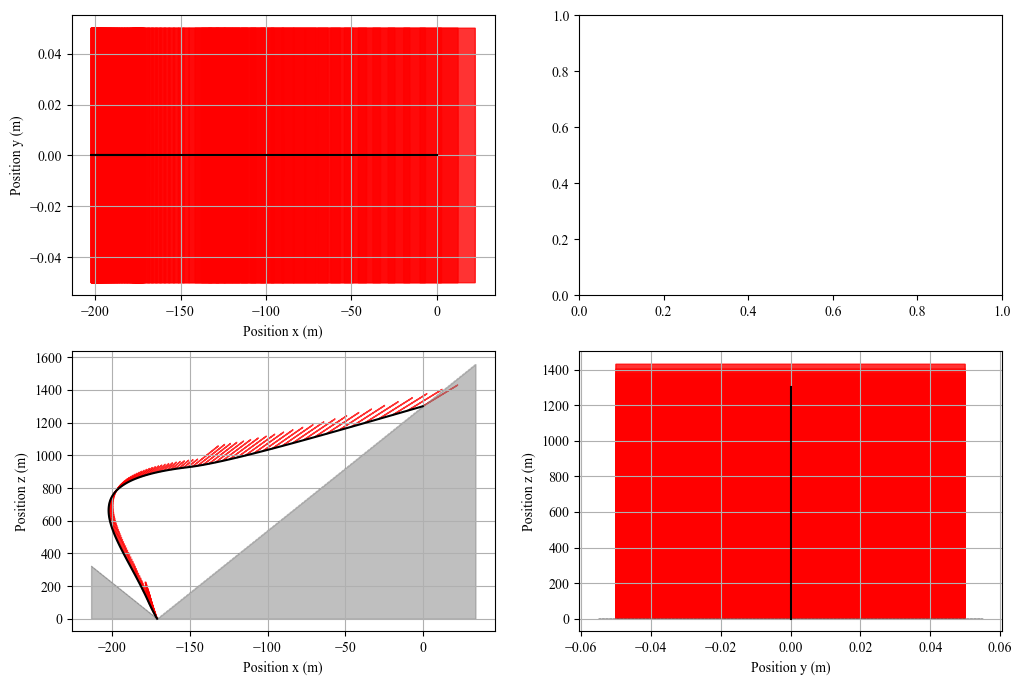

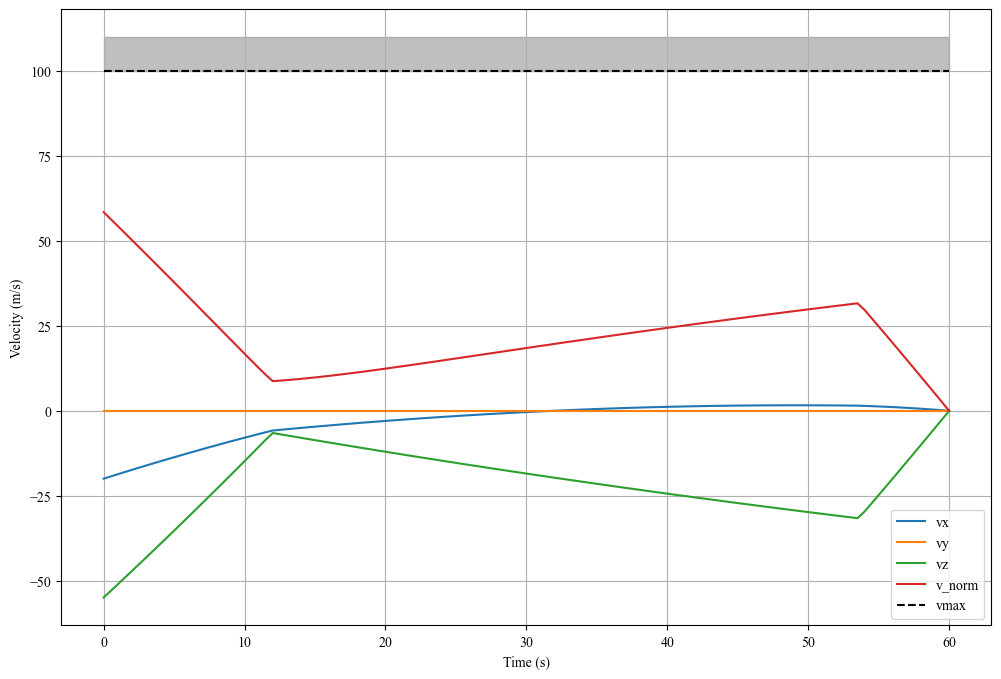

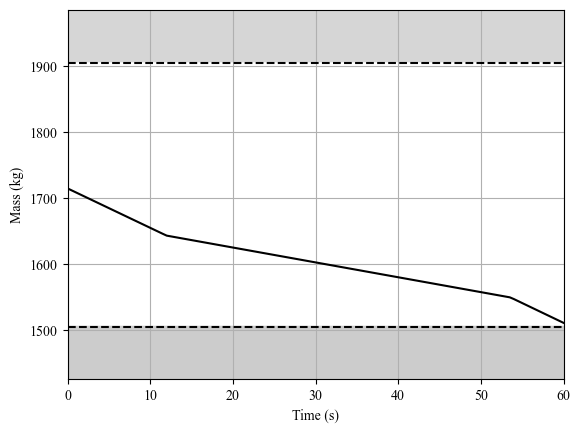

(120,)


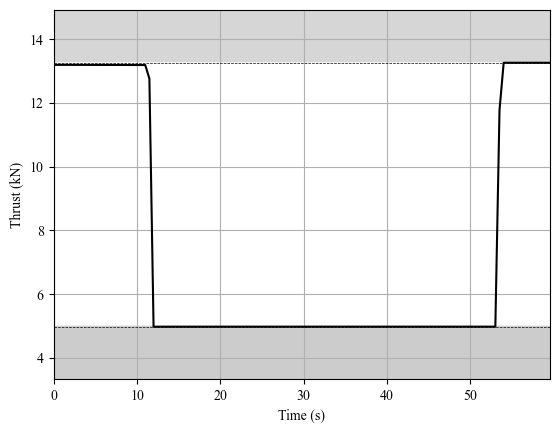

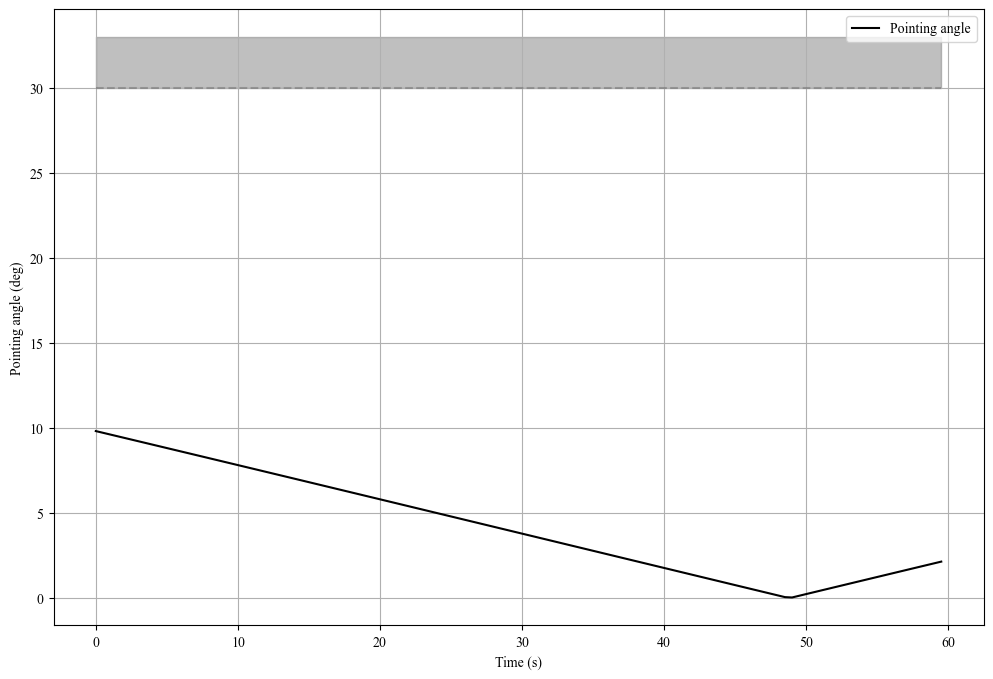

In [5]:
X, U = solve_lcvx(x0, tf, lander, N)
plot_3sides(t[:-1], X, U, uskip=1, gsa=lander.gsa)
plot_vel(t, X, lander.vmax)
plot_mass(t, X, lander.mdry, lander.mwet)
plot_thrust_mag(t[:-1], U, lander.rho2, lander.rho1)
plot_pointing(t[:-1], U, lander.pa)

In [6]:
hidden_layers = [256, 256, 256]
model = lrn.NeuralReach(hidden_layers=hidden_layers)
model.load_state_dict(torch.load('../saved/controllable_set/reachset_train/20231115-025054/models_20231130-175526/mlp_reach/mlp_reach.pt'))
model.eval()

NeuralReach(
  (layers): ModuleList(
    (0): Linear(in_features=5, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.0, inplace=False)
    (9): Linear(in_features=256, out_features=4, bias=True)
    (10): Sigmoid()
  )
)

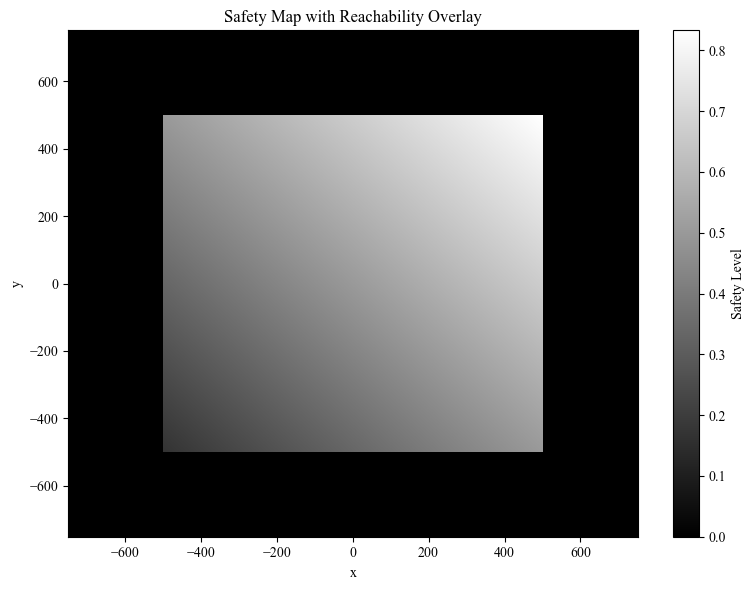

In [7]:
sfmap, _ = make_simple_sfmap(x_range=(-750, 750), y_range=(-750, 750), n_points=1000)
visualize_sfmap(sfmap)

x: [   0.     0.  1300.   -20.     0.   -55.  1714.5], tgo: 60.0, mean safety: 0.48599066994827506


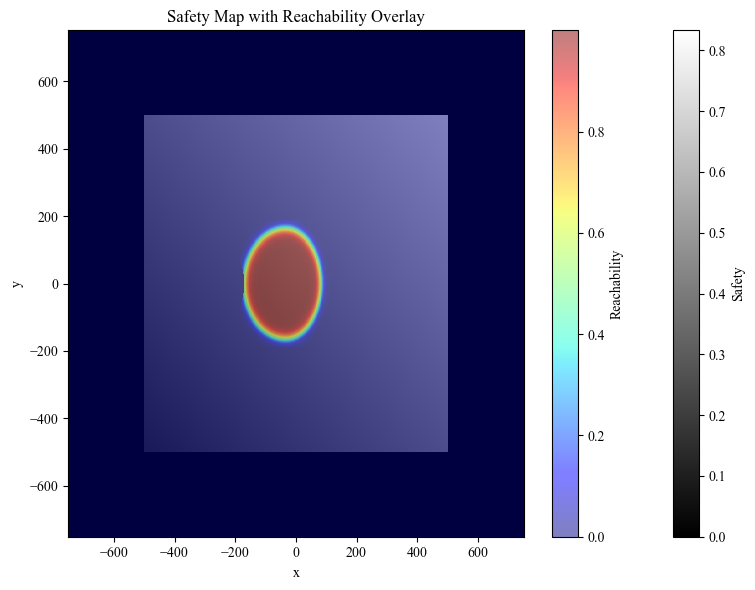

In [8]:
tgo = tf
mean_safety, reach_mask = ic2mean_safety_npy(lander, x0, tgo, model, sfmap, border_sharpness=10)
reach_mask = torch.from_numpy(reach_mask)
print(f'x: {x0}, tgo: {tgo}, mean safety: {mean_safety}')
visualize_nn_reachset(reach_mask, sfmap)

x: [   0.     0.  1300.   -20.     0.   -55.  1714.5], tgo: 60.0, mean safety: 0.48599066994827506


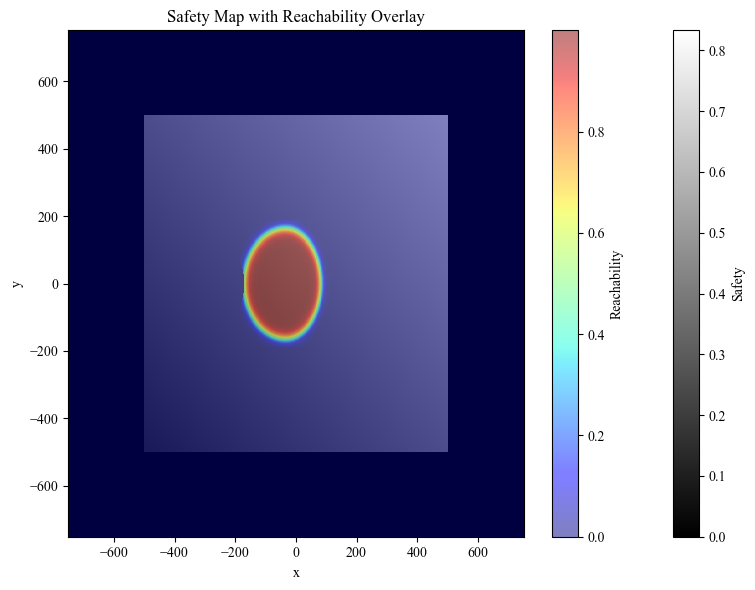

(120, 3) (120, 3) (120,) (120,) (120,)
(120, 3) (120, 3) (120,) (120,) (120,)
x: [ -66.99975143   35.64108287 1062.75259263   -6.99173439   14.50201004
  -39.80057076 1684.45236226], tgo: 55.0, mean safety: 0.49477645028803124


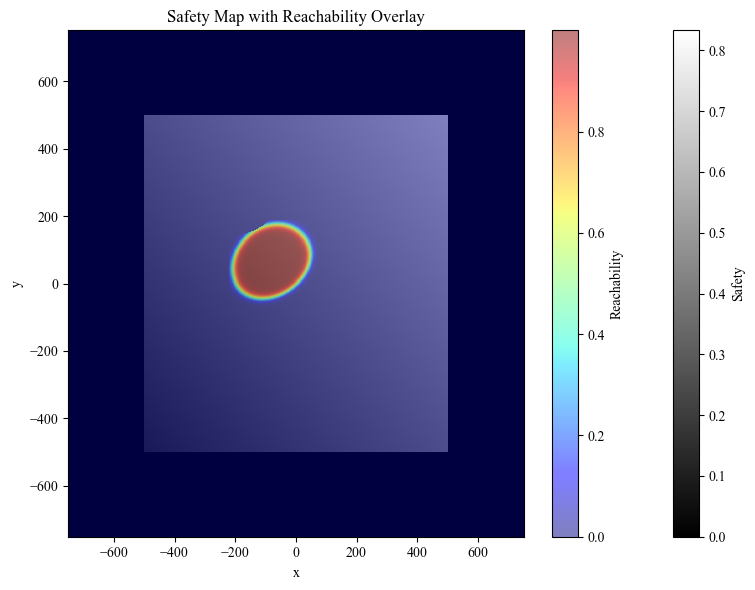

(120, 3) (120, 3) (120,) (120,) (120,)


ValueError: 
function: prob_check_dv
where: D:\bld\pagmo_1699512898121\work\src\problem.cpp, 946
what: A decision vector is incompatible with a problem of type '<class 'src.reachsteering.problems.ReachSteeringCtrl'>': the number of dimensions of the problem is 330, while the decision vector has a size of 360 (the two values should be equal)


In [16]:
import pygmo as pg
from pygmo_plugins_nonfree import snopt7
from src.reachsteering import ReachSteeringCtrl

mass = lander.mwet * 0.9
tf = 60.0

dt = 0.5
N = int(tf / dt)
x0 = np.array([0.0, 0.0, 1300.0, -20.0, 0, -55.0, mass])

kmax = 10
border_sharpness = 10
tgo = tf
Nk = N

mean_safety, reach_mask = ic2mean_safety_npy(lander, x0, tgo, model, sfmap, border_sharpness)
print(f'x: {x0}, tgo: {tgo}, mean safety: {mean_safety}')
visualize_nn_reachset(reach_mask, sfmap)

X, U = solve_lcvx(x0, tgo, lander, Nk)
x0_udp = udp.construct_x(U)

x_hist = []
u_hist = []
t_hist = []

while x0[2] > 100:

    udp = ReachSteeringCtrl(lander, Nk, x0, tgo, sfmap, model, kmax, border_sharpness)
    prob = pg.problem(udp)
    x0_udp = udp.construct_x(U)

    uda = snopt7(screen_output=False, library="C:/Users/ktomita3/libsnopt7/snopt7.dll", minor_version=7)
    ftol = 1e-3
    ctol = 1e-4
    uda.set_integer_option("Major Iteration Limit", 100)
    uda.set_numeric_option("Major optimality tolerance", ftol)
    uda.set_numeric_option("Major feasibility tolerance", ctol)
    uda.set_numeric_option('Minor feasibility tolerance', ctol)
    algo = pg.algorithm(uda)
    algo.set_verbosity(100)

    pop = pg.population(prob, 0)
    pop.push_back(x0_udp)

    result = algo.evolve(pop)
    r, v, m, U = udp.construct_trajectory(result.champion_x)
    X = np.hstack((r, v, m.reshape(-1, 1)))
    t = np.linspace(0, tf, N + 1)

    x_hist.append(X)
    u_hist.append(U)
    t_hist.append(t)

    x0 = np.hstack((r[kmax, :].flatten(), v[kmax, :].flatten(), m[kmax]))
    tgo -= kmax * dt
    Nk -= kmax

    mean_safety, reach_mask = ic2mean_safety_npy(lander, x0, tgo, model, sfmap, border_sharpness)
    print(f'x: {x0}, tgo: {tgo}, mean safety: {mean_safety}')
    visualize_nn_reachset(reach_mask, sfmap)

    

In [11]:
r, v, m, u = udp.construct_trajectory(result.champion_x)

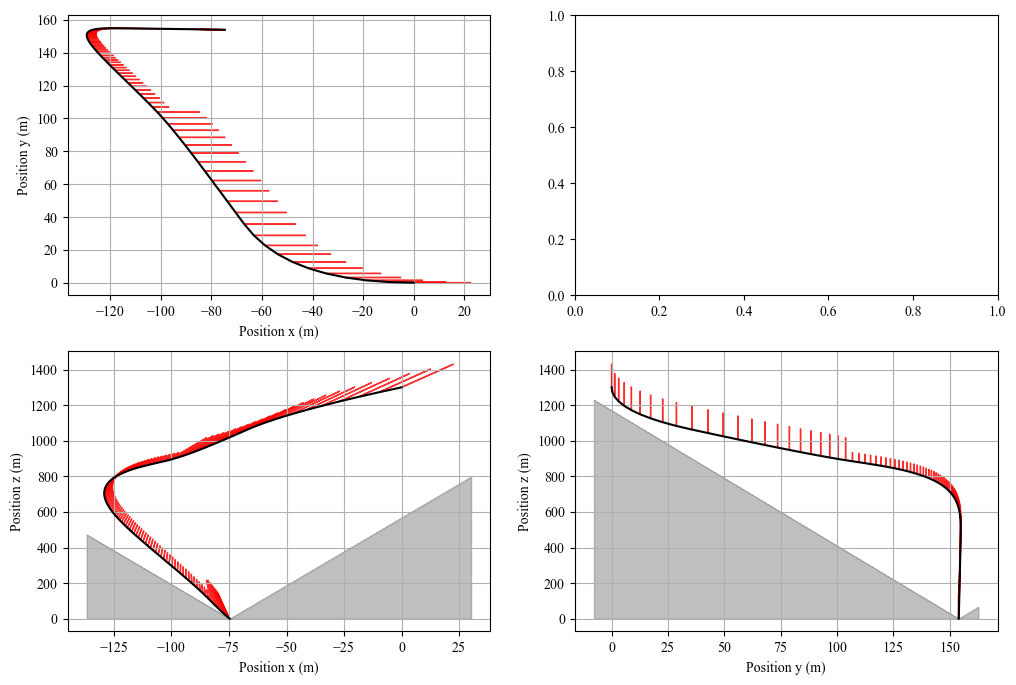

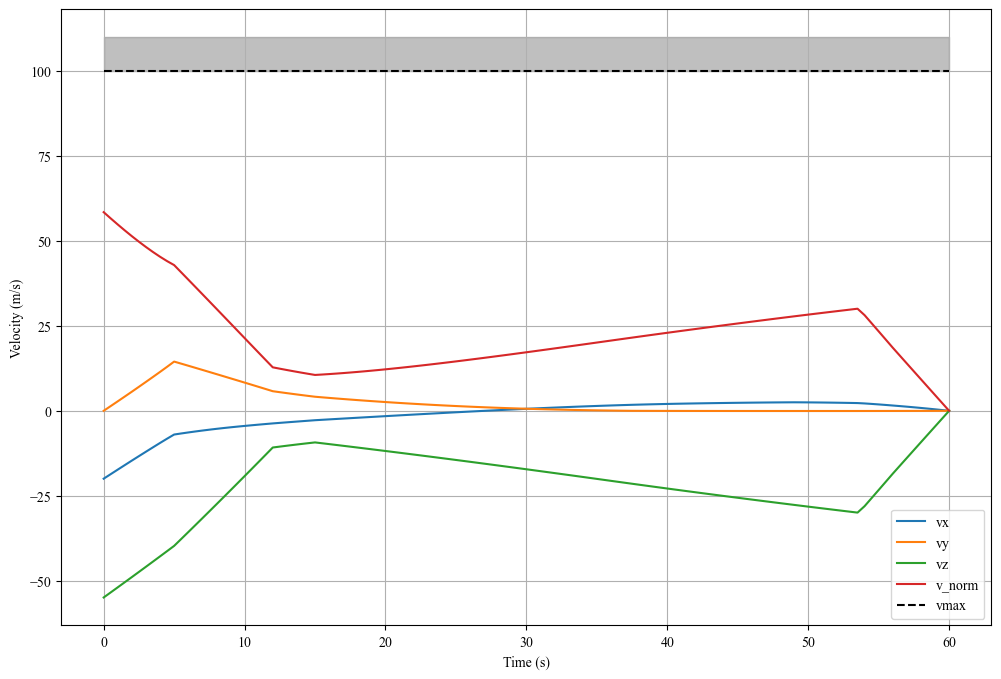

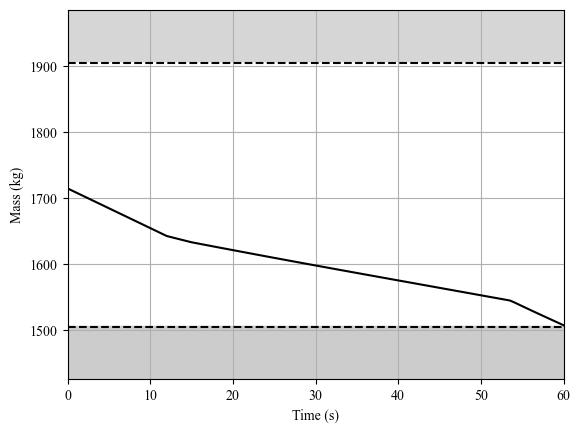

(120,)


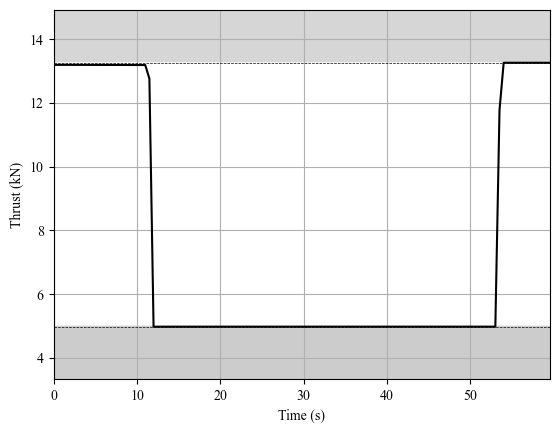

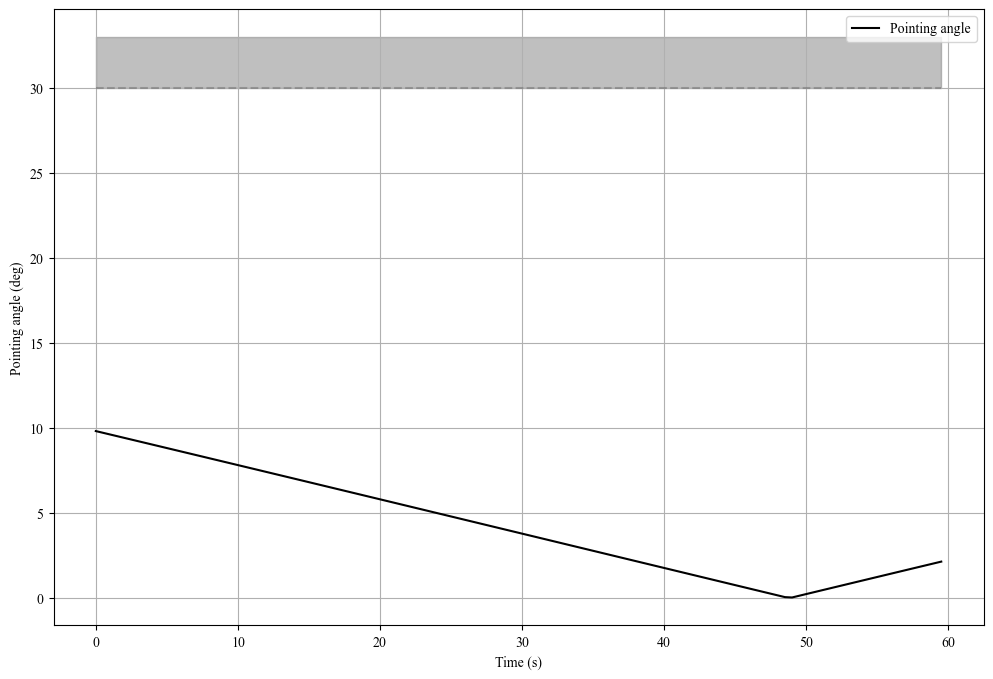

In [12]:
X = np.hstack((r, v, m.reshape(-1, 1)))
t = np.linspace(0, tf, N + 1)
# Plot results
plot_3sides(t[:-1], X, U, uskip=1, gsa=lander.gsa)
plot_vel(t, X, lander.vmax)
plot_mass(t, X, lander.mdry, lander.mwet)
plot_thrust_mag(t[:-1], U, lander.rho2, lander.rho1)
plot_pointing(t[:-1], U, lander.pa)


x: [ -66.99975143   35.64108287 1062.75259263   -6.99173439   14.50201004
  -39.80057076 1684.45236226], tgo: 55.0, mean safety: 0.49477645028803124


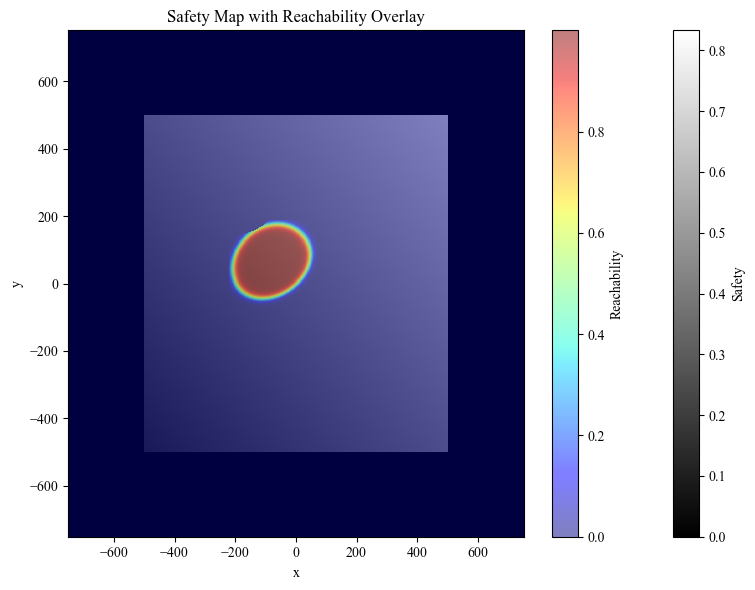

In [15]:
kmax = 10
r_next = r[kmax, :]
v_next = v[kmax, :]
m_next = m[kmax]
x0_next = np.hstack((r_next.flatten(), v_next.flatten(), m_next))
tgo = tf - dt * kmax
mean_safety, reach_mask = ic2mean_safety_npy(lander, x0_next, tgo, model, sfmap, border_sharpness)
print(f'x: {x0_next}, tgo: {tgo}, mean safety: {mean_safety}')
visualize_nn_reachset(reach_mask, sfmap)